In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc


In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

info_path = '/content/drive/MyDrive/Colab Notebooks/datasets/jeju/data_info.csv'
train_path = '/content/drive/MyDrive/Colab Notebooks/datasets/jeju/train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/datasets/jeju/test.csv'
subm_path = '/content/drive/MyDrive/Colab Notebooks/datasets/jeju/sample_submission.csv'

In [ ]:
def data_preprocessing(train,test): #parquet로 바꿔서 train 하나 test하나 가지고 있어야함.
    #이상치 제거
    train_filtered = train[train['target'] <= 80]
    # train_filtered = train

    # 오브젝트 컬럼들 인코딩
    str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
    for i in str_col:
        le = LabelEncoder()
        le=le.fit(train_filtered[i])
        train_filtered[i]=le.transform(train_filtered[i])

        for label in np.unique(test[i]):
            if label not in le.classes_:
                le.classes_ = np.append(le.classes_, label)
        test[i]=le.transform(test[i])

    # 피처 드랍 X Y 나누기
    y_train = train_filtered['target']

    X_train = train_filtered.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted','day_of_week','target'], axis=1)

    test_drop = test.drop(['id','base_date', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted','day_of_week'], axis=1)

    print("X_train.shape: ", X_train.shape)
    print("y_train.shape: ", y_train.shape)
    print("test_drop.shape: ",test_drop.shape)

    return X_train, y_train, test_drop

In [ ]:
# -> 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능합니다.
csv_to_parquet(train_path, 'train')
csv_to_parquet(test_path, 'test')

train Done.
test Done.


In [ ]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')

In [ ]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [ ]:
# columns INFO
INFO = pd.read_csv(info_path)
INFO

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [ ]:
# 결측치 없음 // 오브젝트 타입 다수 //
train.info()
print(train.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [ ]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [ ]:
X_train,y_train,test = data_preprocessing(train,test)

X_train.shape:  (4701217, 15)
y_train.shape:  (4701217,)
test_drop.shape:  (291241, 15)


# Modeling

In [ ]:
LR = lgb.LGBMRegressor(random_state=42).fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.979609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 4701217, number of used features: 14
[LightGBM] [Info] Start training from score 42.788442


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 15)
(4701217,)
(291241, 15)


In [ ]:
test['start_turn_restricted']

0         0
1         0
2         0
3         0
4         0
         ..
291236    0
291237    0
291238    1
291239    0
291240    0
Name: start_turn_restricted, Length: 291241, dtype: int64

In [ ]:
pred = LR.predict(test)

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/jeju/sample_submission.csv')

In [ ]:
sample_submission['target'] = pred
sample_submission.to_csv("./submit.csv", index = False)
sample_submission

,id,target
0,TEST_000000,27.285912
1,TEST_000001,43.936504
2,TEST_000002,60.442690
3,TEST_000003,35.975236
4,TEST_000004,37.709819
...,...,...
291236,TEST_291236,45.501121
291237,TEST_291237,52.190526
291238,TEST_291238,21.864872
291239,TEST_291239,25.487352


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

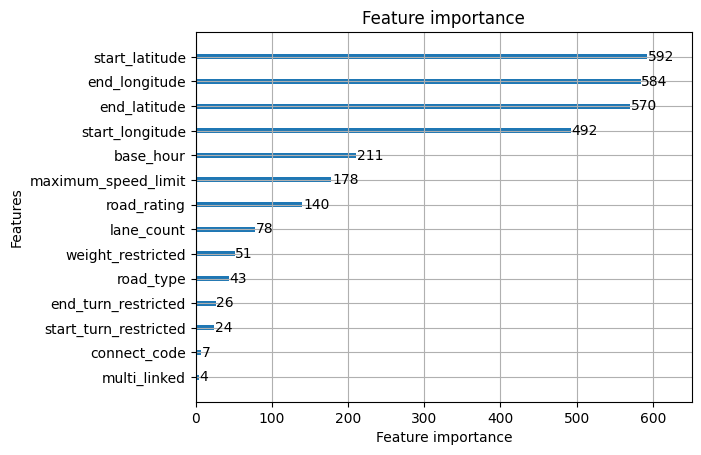

In [ ]:
from lightgbm import plot_importance
plot_importance(LR)